In [1]:
import numpy as np
import time
import cv2
from boosting_classifier import Boosting_Classifier
from visualizer import Visualizer
from im_process import normalize
from utils import *

In [2]:
%load_ext line_profiler

In [3]:
flag_subset = True
boosting_type = 'Ada' #'Real' or 'Ada'
training_epochs = 101 if not flag_subset else 21
act_cache_dir = 'tst_wc_activations.npy' if not flag_subset else 'tst_wc_activations_subset.npy'
chosen_wc_cache_dir = 'tst_chosen_wcs.pkl' if not flag_subset else 'tst_chosen_wcs_subset.pkl'

In [4]:
#data configurations
pos_data_dir = '../newface16'
neg_data_dir = '../nonface16'
image_w = 16
image_h = 16
data, labels = load_data(pos_data_dir, neg_data_dir, image_w, image_h, flag_subset)
data = integrate_images(normalize(data))

Load in 200 images, 100 faces, 100 non-faces


In [5]:
#number of bins for boosting
num_bins = 25

#number of cpus for parallel computing
num_cores = 8 if not flag_subset else 1 #always use 1 when debugging

In [6]:
#create Haar filters
filters = generate_Haar_filters(4, 4, 16, 16, image_w, image_h, flag_subset)

In [7]:
#create visualizer to draw histograms, roc curves and best weak classifier accuracies
drawer = Visualizer([10, 20, 50, 100], [1, 10, 20, 50, 100])

In [8]:
#create boost classifier with a pool of weak classifier
boost = Boosting_Classifier(filters, data, labels, training_epochs, num_bins, drawer, num_cores, boosting_type)

In [9]:
#calculate filter values for all training images
start = time.clock()
activations = boost.calculate_training_activations(act_cache_dir, act_cache_dir)
end = time.clock()
print('%f seconds for activation calculation' % (end - start))

Calcuate activations for 1000 weak classifiers, using 200 imags.
[Find cached activations, tst_wc_activations_subset.npy loading...]
0.006776 seconds for activation calculation


# Code Testing

In [ ]:
#weight initialization
weights = [1/200.0]*200

## Single Weak Classifier - Adaboost WC Object

In [ ]:
wc1 = boost.weak_classifiers[0]

In [ ]:
print(wc1.polarity)
print(wc1.threshold)

In [ ]:
min(wc1.activations)

In [ ]:
min_error = wc1.calc_error(weights, labels)

In [ ]:
min_error

Filter visualization

In [ ]:
import matplotlib.patches as patches
def visualize_haar_filter(topwcs, grid_size = (4,5), figsize = (10,8)):
    fig = plt.figure(figsize = figsize)
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, 
                        hspace = 0.05, wspace = 0.05)
    for indx, wc in enumerate(topwcs):
        
        ax = fig.add_subplot(grid_size[0], grid_size[1], indx+1, xticks=[], yticks=[])
        ax.set_xlim(0, 16)
        ax.set_ylim(0, 16)
        
        for i in range(len(wc.plus_rects)):
            pos_xy = (wc.plus_rects[i][0], wc.plus_rects[i][1])
            pos_width = wc.plus_rects[i][2] -wc.plus_rects[i][0] +1
            pos_height = wc.plus_rects[i][3] - wc.plus_rects[i][1] +1

            rect_pos = patches.Rectangle(pos_xy,pos_width,pos_height, edgecolor = 'black', facecolor='black')
            ax.add_patch(rect_pos)

        for j in range(len(wc.minus_rects)):
            neg_xy = (wc.minus_rects[j][0], wc.minus_rects[j][1])
            neg_width = wc.minus_rects[j][2] -wc.minus_rects[j][0] +1
            neg_height = wc.minus_rects[j][3] - wc.minus_rects[j][1] +1

            rect_neg = patches.Rectangle(neg_xy,neg_width,neg_height,linewidth=1,edgecolor='black',facecolor='none')
            ax.add_patch(rect_neg)
    plt.show()

In [ ]:
print(boost.weak_classifiers[900].plus_rects)
print(boost.weak_classifiers[900].minus_rects)

In [ ]:
visualize_haar_filter(boost.weak_classifiers[900:920])

## Multiple weak classifiers as attributes of Boosting Classifier object

In [ ]:
print(boost.weak_classifiers[0].polarity)
print(boost.weak_classifiers[0].threshold)

print(boost.weak_classifiers[1].polarity)
print(boost.weak_classifiers[1].threshold)

In [ ]:
classifier_errors = boost.weak_classifier_errors(weights)

In [ ]:
print(boost.weak_classifiers[0].polarity)
print(boost.weak_classifiers[0].threshold)

print(boost.weak_classifiers[1].polarity)
print(boost.weak_classifiers[1].threshold)

In [ ]:
print(classifier_errors[0])
print(classifier_errors[1])

In [ ]:
%lprun -f boost.train boost.train()

In [ ]:
boost.num_cores = 8

In [ ]:
%lprun -f boost.train boost.train()

In [10]:
chosenWeakClassifiers = boost.train(chosen_wc_cache_dir)

100%|██████████| 21/21 [02:20<00:00,  6.73s/it]


In [ ]:
a = [10, 20, 50, 100, 1, 10, 20, 50, 100]
20 in a

In [ ]:
len(boost.chosen_wcs)

In [ ]:
boost.visualizer.weak_classifier_accuracies

In [ ]:
boost.visualizer.strong_classifier_scores

In [ ]:
boost.sc_function(boost.data[0])

In [ ]:
boost.set_strong_classifier_scores()

In [11]:
boost.visualizer.histogram_intervals = [1,10, 20]
boost.visualizer.top_wc_intervals = [1,10, 20]

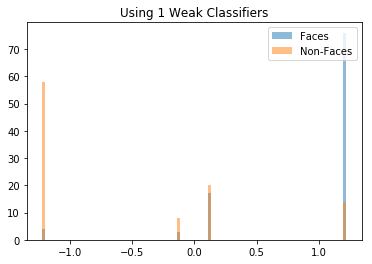

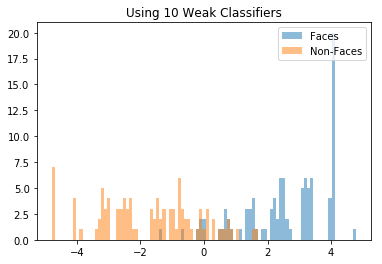

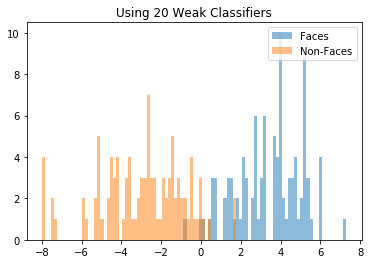

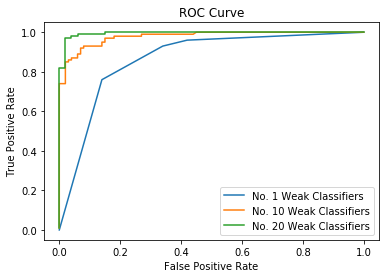

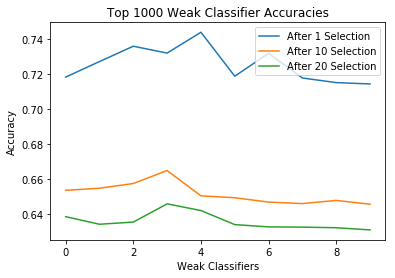

In [12]:
boost.visualize()

In [ ]:
boost.visualizer.draw_wc_accuracies()

In [ ]:
boost.visualizer.weak_classifier_accuracies

visualize the training error of the strong classifier over the steps of T

In [ ]:
#original_img = cv2.imread('../Testing_Images/Face_1.jpg', cv2.IMREAD_GRAYSCALE)
#result_img = boost.face_detection(original_img)
#cv2.imwrite('Result_img_%s.png' % boosting_type, result_img)

## Toy example

### Initializations

In [ ]:
fltr_indices = [0, 100, 300, 500, 800]
toy_filters = [filters[i] for i in fltr_indices]#five filters
toy_data = np.vstack((np.array(data[0:5, :, :]), np.array(data[190:195, :, :]))) #10 images
l1 = list(labels[0:5])
l2 = list(labels[190:195])
toy_labels =  np.array(l1+ l2)  #10 labels

In [ ]:
toy_boost = Boosting_Classifier(toy_filters, toy_data, toy_labels, 4, num_bins, drawer, 1, "Ada")

In [ ]:
initial_toy_weights = [.1]*10
initial_toy_weights

### Testing Activation Training

In [ ]:
toy_boost.weak_classifiers[0]

In [ ]:
print(toy_boost.weak_classifiers[0].activations)

Setting up activations

In [ ]:
activations = toy_boost.calculate_training_activations("toy_act_dir.npy", "toy_act_dir.npy")

In [ ]:
print(activations.shape)
print(activations)

### Testing Weak Classifier Class Functions

In [ ]:
exampleWeakClassifier = toy_boost.weak_classifiers[0]
print("Range of activations: ", min(exampleWeakClassifier.activations), " to ", 
      max(exampleWeakClassifier.activations))

#### Weak Classifier Helper Functions

In [ ]:
exampleWeakClassifier.activations

In [ ]:
#the predicted labels from the weak classifier
predictions = exampleWeakClassifier.make_classification_predictions(0)
print(predictions)

In [ ]:
toy_labels

In [ ]:
#indicates which predictions were incorrect
exampleWeakClassifier.classification_indicator_function(toy_labels, predictions)

In [ ]:
#calculate weighted total error (here we have 7 wrong 3 right)
exampleWeakClassifier.weighted_error_calc(initial_toy_weights, toy_labels, predictions)

#### Main Error Calculation

In [ ]:
print("Classifier 1:")
print("min error: ", toy_boost.weak_classifiers[0].calc_error(initial_toy_weights, toy_labels))
print("th: ", toy_boost.weak_classifiers[0].threshold)
print("pol: ", toy_boost.weak_classifiers[0].polarity)

print("Classifier 2:")
print("min error: ", toy_boost.weak_classifiers[1].calc_error(initial_toy_weights, toy_labels))
print("th: ", toy_boost.weak_classifiers[1].threshold)
print("pol: ", toy_boost.weak_classifiers[1].polarity)

print("Classifier 3:")
print("min error: ", toy_boost.weak_classifiers[2].calc_error(initial_toy_weights, toy_labels))
print("th: ", toy_boost.weak_classifiers[2].threshold)
print("pol: ", toy_boost.weak_classifiers[2].polarity)

print("Classifier 4:")
print("min error: ", toy_boost.weak_classifiers[3].calc_error(initial_toy_weights, toy_labels))
print("th: ", toy_boost.weak_classifiers[3].threshold)
print("pol: ", toy_boost.weak_classifiers[3].polarity)

print("Classifier 5:")
print("min error: ", toy_boost.weak_classifiers[4].calc_error(initial_toy_weights, toy_labels))
print("th: ", toy_boost.weak_classifiers[4].threshold)
print("pol: ", toy_boost.weak_classifiers[4].polarity)

In [ ]:
toy_boost.weak_classifiers[3].activations

In [ ]:
toy_boost.weak_classifiers[3].activations > 5.03

#### Function Profiler for Optimization

In [ ]:
%lprun -f wc1.calc_error wc1.calc_error(weights, labels)

### Testing Boosting Classifier Class Functions

In [ ]:
#Predictions from the weak classifiers
print(toy_boost.labels == 1) #correct labels
for classifier in toy_boost.weak_classifiers:
    print(classifier.activations*classifier.polarity > classifier.threshold*classifier.polarity)

#### Testing Inside components of Train function

In [ ]:
min_error = [classifier.calc_error(initial_toy_weights, toy_boost.labels)for classifer in toy_boost.weak_classifiers]
print("min error: ", min_error)    

select the best weak classifier

In [ ]:
import copy
bestWCIndex = min_error.index(min(min_error))
bestWClassifier = copy.deepcopy(toy_boost.weak_classifiers[bestWCIndex])
print(bestWClassifier)
print(bestWClassifier.polarity)
print(bestWClassifier.threshold)

#### Test Calculate Alpha

In [ ]:
alph = toy_boost.calculate_alpha(min(min_error))
selectedWC.append([alph, bestWClassifier])
print("alpha: ", alph)

In [ ]:
#check, the error is .3, plug into the formula for alpha
.5*(np.log((1-.3)/.3))

In [ ]:
#for bestWC, which data points did it incorrectly classify?
print(toy_boost.labels == 1) #correct labels
print(bestWClassifier.activations*bestWClassifier.polarity > bestWClassifier.threshold*bestWClassifier.polarity)

#### Test WEight Updating

In [ ]:
initial_toy_weights

In [ ]:
weights = toy_boost.update_weights(bestWClassifier, initial_toy_weights, alph)

In [ ]:
weights

In [ ]:
min_error_2 = [classifier.calc_error(weights, toy_boost.labels)for classifer in toy_boost.weak_classifiers]
print("min error: ", min_error_2 )
    
bestWCIndex = min_error_2.index(min(min_error_2))
bestWClassifier = copy.deepcopy(toy_boost.weak_classifiers[bestWCIndex])
print(bestWClassifier)
print(bestWClassifier.polarity)
print(bestWClassifier.threshold)

In [ ]:
#### Test Train Function with Optimization

In [ ]:
%lprun -f toy_boost.train toy_boost.train()

In [ ]:
toy_boost.train()

In [ ]:
[toy_boost.sc_function(img) for img in toy_boost.data]

In [ ]:
toy_boost.set_strong_classifier_scores

In [ ]:
toy_boost.visualizer.strong_classifier_scores

Perform hard mining after all the training epochs are over, using the final strong classifier to get the wrong patches, and then restart the training process with the added wrong patches?